In [ ]:
# ------------------------------------------
# Was tut dieses Skript?
# Dieses Skript verarbeitet Mapillary-Coverage-Daten für Deutschland,
# filtert sie nach Zeit und Pano-Status, erstellt Geometriepuffer und speichert die Ergebnisse als Parquet-Dateien.
# ------------------------------------------

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from datetime import datetime, timezone

import os
import glob
import json



from config import GEOFABRIK_CONFIG, PROCESSING_CONFIG, MAPILLARY_CONFIG, TILES_CONFIG

In [2]:
# Input: (Parquet File) mapillary coverage lines per tile 

# Output: Buffered lines per tile for pano only and all

In [3]:
# Alle Parquet-Dateien zusammenladen
parquet_files = glob.glob( PROCESSING_CONFIG["ml_output_folder"]+ "/mapillary_coverage_DE-*.parquet")
mapillary_coverage = gpd.GeoDataFrame(pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True))

mapillary_coverage

,geometry,captured_at,creator_id,id,image_id,is_pano,organization_id,tile_x,tile_y
0,"MULTILINESTRING ((9.73389 53.61547, 9.7381 53....",2024-01-27,109115837985025,FOU8SJkuvrtCHVEbh2sDwB,713387037574995,False,NaN,8635,5290
1,"MULTILINESTRING ((9.75586 53.61218, 9.75291 53...",2024-04-08,109115837985025,JBNqgCdyinpU8Sbm0M5Vw3,917899676790197,False,NaN,8635,5290
2,"MULTILINESTRING ((9.74369 53.617, 9.74961 53.6...",2023-09-03,103929839184852,1c8mMOn47jCudefNIpov0J,284202811008700,False,NaN,8635,5290
3,"MULTILINESTRING ((9.75036 53.60555, 9.75056 53...",2024-05-11,103929839184852,QevN1BhYEr0zTUJ6nwuoy3,1486192815625319,False,NaN,8635,5290
4,"MULTILINESTRING ((9.73389 53.61546, 9.73575 53...",2023-11-04,109115837985025,80CENZBjJ4etvdOiQUGPmx,981660149592834,False,NaN,8635,5290
...,...,...,...,...,...,...,...,...,...
897566,"LINESTRING (11.27252 54.41665, 11.27267 54.416...",2025-06-20,102923368613804,W4D09N7mFqjc56tAS2yzvh,534028509794768,False,NaN,8705,5228
897567,"LINESTRING (11.29394 54.41217, 11.29362 54.412...",2025-06-20,102923368613804,kCmviT24e9ybVKD0uzqhpO,1416873349588918,False,NaN,8705,5228
897568,"LINESTRING (11.27197 54.41679, 11.27223 54.416...",2025-06-20,102923368613804,YonUfQTgW0XFaCrZSDKy6w,1945022226314852,False,NaN,8705,5228
897569,"LINESTRING (11.29395 54.41219, 11.29584 54.412...",2025-06-20,102923368613804,W4D09N7mFqjc56tAS2yzvh,534028509794768,False,NaN,8706,5228


In [4]:
# Get oldest date from all parquet files

# extract date part from filenames (expects pattern ..._YYYY-MM-DD.parquet)
date_strs = [os.path.basename(f).rsplit(".", 1)[0].split("_")[-1] for f in parquet_files]
dates = pd.to_datetime(date_strs, format="%Y-%m-%d", errors="coerce")

# oldest date -> variable and print
oldest_date = dates.min()  # pandas.Timestamp or NaT
oldest_date_str = oldest_date.strftime("%Y-%m-%d") if pd.notnull(oldest_date) else None
print(oldest_date_str)


# use existing oldest_date or fallback to oldest_date_str
ts = oldest_date if 'oldest_date' in globals() else pd.to_datetime(oldest_date_str)

iso_ts = pd.Timestamp(ts).strftime("%Y-%m-%dT%H:%M:%SZ") if pd.notnull(ts) else None

metadata = {"ml_data_from": iso_ts}

with open("ml_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("ml_metadata.json written:", metadata)



2025-10-18
ml_metadata.json written: {'ml_data_from': '2025-10-18T00:00:00Z'}


### plot to check if its all ok

In [7]:
# ax = mapillary_coverage.plot(column="is_pano", alpha=0.5, legend=True)
# #plt.title("No Time Filter: Both Pano and Non-Pano")
# plt.title("Germany - later than 2023-01-01: Both Pano and Non-Pano")

Text(0.5, 1.0, 'Berlin - later than 2023-01-01: Both Pano and Non-Pano')

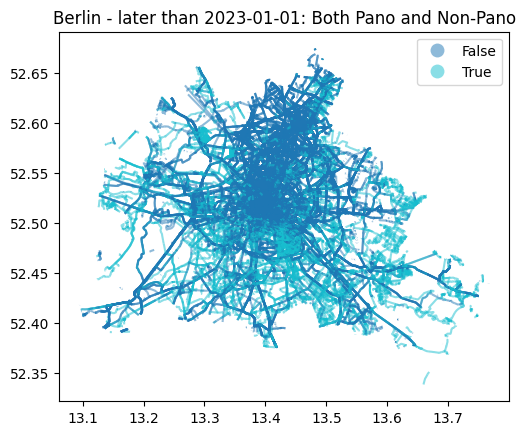

In [8]:
bland = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json")
bland=bland[bland["id"].isin(["DE-BE"])]


mapillary_coverage_clipped = mapillary_coverage.clip(bland)

ax = mapillary_coverage_clipped.plot(column="is_pano", alpha=0.5, legend=True)
#plt.title("No Time Filter: Both Pano and Non-Pano")
plt.title("Berlin - later than 2023-01-01: Both Pano and Non-Pano")

In [9]:

# # Convert 'captured_at' to datetime
# mapillary_coverage_clipped['captured_at'] = pd.to_datetime(mapillary_coverage_clipped['captured_at'])

# # Create a naive Timestamp with the desired date (no timezone information)
# filter_date = pd.Timestamp(datetime(2025, 1, 1))

# # Filter rows where 'captured_at' is after January 1, 2023
# filtered_mapillary_coverage = mapillary_coverage_clipped[
#     mapillary_coverage_clipped['captured_at'] >= filter_date
# ]

# ax = filtered_mapillary_coverage.plot(column="is_pano", alpha=0.5, legend=True)
# plt.title("later than 2025-01-01: Both Pano and Non-Pano")

##  explode, buffer, dissolve, save 

In [ ]:

# berlin both pano and non-pano ~ 1min
## Germany: both pano and non-pano ~ 25min

## 25-05-12:
## Germany: both pano and non-pano ~ 11min

## 25-10-07:
## Germany: both pano and non-pano ~ 8min

## 25-10-18:
## Germany: both pano and non-pano ~ 8min


# explode the geometry to make buffering faster
mapillary_coverage_exploded = mapillary_coverage.explode(index_parts=False, ignore_index=True)

# create 10m buffers for all the lines
mapillary_coverage_buffered = mapillary_coverage_exploded.to_crs(25832).copy()
mapillary_coverage_buffered['geometry'] = mapillary_coverage_buffered['geometry'].buffer(PROCESSING_CONFIG["buffer_distance"])

# dissolve by tile_x, tile_y and is_pano
mapillary_coverage_dissolved = mapillary_coverage_buffered.dissolve(by=['tile_x', 'tile_y','is_pano'])
mapillary_coverage_dissolved = mapillary_coverage_dissolved.reset_index()


# keep only necessary columns
mapillary_coverage_dissolved_cleaned = mapillary_coverage_dissolved[['tile_x', 'tile_y', 'is_pano', 'geometry']].copy()


# write dissolved buffered file
#mapillary_coverage_dissolved_cleaned.to_parquet("ml_output/mapillary_coverage_germany_buffered10m_dissolved_23-01-01_until_25-10-07.parquet")
mapillary_coverage_dissolved_cleaned.to_parquet( PROCESSING_CONFIG["ml_output_folder"]+  "/mapillary_coverage_germany_buffered_latest.parquet")

In [ ]:
#mapillary_coverage_dissolved_cleaned[mapillary_coverage_dissolved_cleaned.is_pano==True][:1].plot()